In [1]:
import RNA
# Code folding for jupyter
import notebook
E = notebook.nbextensions.EnableNBExtensionApp()
E.enable_nbextension('usability/codefolding/main')

from local_dotplot_lib import *



In [2]:
import random
random.seed(10)
np.random.seed(100)
E.enable_nbextension('usability/codefolding/main')

# >X57128.1_136-761-context-only
# cuaacuuucgcaagcgagucucgcgacaauugcagaagccuagugaguugcggucguguuuguugcuuaaaccagcaguccgucuacaacuccucggcuacaucauaacuugccuuugugcucuccccugcgagcgccgcucuccgccgcuugcacggcgccgcugcuuaaucgucgaaaauccugcaacagcugccaacaaugacucaagucuuauaggccacugccuggugcuucccguuucuugaaagauaugaaggcacccgggagaagccgggaagcaagcgucagugguggccgcugccuccacggcaaugcgucaucacucucacugcugccaggcagggcugcgacaaugccuggcgaaauacaucagcgcgcgguaagcgaaagcggcucaucgaaguacuccgcgacggggggacaacaguggccgagaaugccacuccacucccgucaccccagaagcgcccucggucaguuccuguccauuuagcaaagacaacaagacagaaacaauuuguuuccacuacacuuauuuccuccuaaacgguaggcucauuaaguuaaauugguaguuacaucauguguuaacgugac

# >X57128.1_614-639 
# gaaaaggcucuuuucagagccacuca
context_histone = "cuaacuuucgcaagcgagucucgcgacaauugcagaagccuagugaguugcggucguguuuguugcuuaaaccagcaguccgucuacaacuccucggcuacaucauaa\
cuugccuuugugcucuccccugcgagcgccgcucuccgccgcuugcacggcgccgcugcuuaaucgucgaaaauccugcaacagcugccaacaaugacucaagucuuauaggccacugcc\
uggugcuucccguuucuugaaagauaugaaggcacccgggagaagccgggaagcaagcgucagugguggccgcugccuccacggcaaugcgucaucacucucacugcugccaggcagggcu\
gcgacaaugccuggcgaaauacaucagcgcgcgguaagcgaaagcggcucaucgaaguacuccgcgacggggggacaacaguggccgagaaugccacuccacucccgucaccccagaagcgc\
ccucggucaguuccuguccauuuagcaaagacaacaagacagaaacaauuuguuuccacuacacuuauuuccuccuaaacgguaggcucauuaaguuaaauugguaguuacaucauguguuaacgugac"
histone = "gaaaaggcucuuuucagagccacuca"
trna = "ggcggcauggccaagcgguaaggcaggggacugcaaauccuuuauccccaguucaaaucugggugccgccu";
# tran2 >X70810.2_30807-30878
trna2="GCCUUUUUAGCUCAGUGGUAGAGCAUUGUAUUUGUAAUGCGGUGGUCGUCGGUUCGAAUCCGACAAAAGGCU"
context_trna2 = "uaugauauuuuuauaguguuuuauucauggaucaauucuauuuuuuauuagcacgugguuuuauuuuguuaaauuguaaa\
uccguauuauuuauaaauugauccuagcucaaaguucaguauuuuuaaauuuuuuuaguuuuaaauaaauauuuuguauaaaaaugugugauuauuu\
aaaagauuucuuccauuucaugacuuuuaauuuuaaaaaaaaauuucaaguauguggccauguauccguauuuggagacaagaagcaagaaaagguu\
uucuuuauaaaaaaguuuagguguuu\
uuauuuuagguaacuuuuuaagcguguuucaccggugcauucaguuuuuuuaguaaugcauaugucauugcaauuuuagcauuauguaaucuuaaa\
agcuuuugucauauuucucaacugcuaugauauauugauaggaguccuucucaauggaugcgggagaauaaauauauuguucacgguagucuaaggc\
ucauugcccccuuuuuaaagucuuagcuuucaucaugcccaggauaaaauaaucaguguugcaauaguucaaauaagcuuaauucaaaguuuauuuuagaggaucgg"

# print compute_mfe_probability("uauuuuuauaguguuuuauucauggaucaauucuauuuuuuauuagcacgugguuuuauuuuguuaa\
# auuGCCUUUUUAGCUCAGUGGUAGAGCAUUGUAUUUGUAAUGCGGUGGUCGUCGGUUCGAAUCCGACAAAAGGCUguaaauccguauuauuuauaaau\
# ugauccuagcucaaaguucaguauuuuuaaauuuuuuuaguuuuaaau")

# print compute_mfe_probability("cuuucgcaagcgagucucgcggaaaa")
# np_bp_probs = getBPPM("cuuucgcaagcgagucucgcggaaaa")
# np_bp_probs[np_bp_probs.nonzero()]
 

In [9]:
%matplotlib inline
E.enable_nbextension('usability/codefolding/main')

import RNA
import numpy as np 
from altschulEriksonDinuclShuffle import dinuclShuffle
import random
# def get_subsequence_prob(rna_seq):


from matplotlib import pyplot as plt
import mpld3 
from mpld3 import plugins
# mpld3.enable_notebook()
import pandas as pd

def plot_scatter(x, y, xlab, ylab, labels, fig, ax, color=None, scale='linear'):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if color is not None:
        cc = color
    else:
        cc = 'skyblue'
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_yscale(scale)
    ax.set_xlim([1,600])
    if scale =='log':
       ax.set_yscale(scale)
       ax.set_ylim([1e-5, 20])
    if scale =='linear':
       ax.set_yscale(scale)
       ax.set_ylim([-0.05,1.3])
    
    points = ax.scatter(x, y, s=10, linewidth='0', c=cc)
    legend = ax.legend(loc='upper right', shadow=False)

    # Connect d3 points with mouse over lables
    tooltip = plugins.PointLabelTooltip(points, labels)
    plugins.connect(fig, tooltip)

def plot_scatter_df(mydf, pdfname='defaultname', scale='linear', what='both'):
    
    if what == 'both':
        fig = plt.figure(figsize=(5, 10))
        subplot_num = 210
    else:
        fig = plt.figure(figsize=(6, 4))
        subplot_num = 110
    
    mpld3.plugins.clear(fig)  # clear all plugins from the figure    

    # if scale == 'linear':
    #    ax.set_ylim([min(-20,  min(mydf[nameY])),max(30, max(mydf[nameY]))])
    # import math
    #     yrange = round(mydf[nameY].median()/10) * 10
    #     print "{} median: {}".format(nameY, mydf[nameY].median())
    #     ax.set_ylim([yrange-100, yrange+100])#[mydf[nameY].median() - 10 ,mydf[nameY].median() + 10])
    if what == 'both' or what=='split':
        subplot_num+=1
        ax = fig.add_subplot(subplot_num)
        plot_scatter(mydf['context-length'], mydf['split'], 'context-length', 'Probability', 
                     [str(v) for v in list(mydf.index.values)], fig, ax, 
                     color='g', scale=scale)
    if what == 'both' or what=='extend':
        subplot_num+=1
        ax = fig.add_subplot(subplot_num)
        plot_scatter(mydf['context-length'], mydf['extend'], 'context-length', 'Probability',
                     [str(v) for v in list(mydf.index.values)], fig, ax, 
                     color='b', scale=scale)

    fig.suptitle(pdfname+"-"+what, y =0.96)
    fig.savefig (pdfname+"-"+what+".svg", dpi=600) #, bbox_inches='tight')

def my_eval(rna_seq, context, l_pos, r_pos, rna_split_pos, step=10):
    context = context.upper()
    cont_lengths, inner_probs, outer_probs = [] , [], []
    for context_len in range(0,600,step):
        # select a range of the context, each time reshuffle to not stick into a (rare) sub-minimal case
        selection = dinuclShuffle(context)[0:context_len]
        # Insert the rna inbetween selection, insert position is from a normal distribution with mean 
        # be the center of the selected context
        center_pos = len(selection)/2
        insert_pos = max(0, int(np.random.normal(center_pos, 1+center_pos*0.1 )))
        print "(", context_len, center_pos, insert_pos, ")", 
        full_seq_inner = selection[:insert_pos] +  rna_seq + selection[insert_pos:]
        full_seq_outer = rna_seq[:rna_split_pos] +  selection + rna_seq[rna_split_pos:]
#         print full_seq_outer
    #     print full_seq[insert_pos:insert_pos+len(histone)]
    #     print full_seq[insert_pos+l_pos], full_seq[insert_pos+r_pos]
        structure = ""
        RNA.pf_fold(full_seq_inner, structure)
        inner_prob = RNA.get_pr(insert_pos+l_pos+1,insert_pos+r_pos+1)

        RNA.free_pf_arrays()

        RNA.pf_fold(full_seq_outer, structure)
        outer_prob = RNA.get_pr(l_pos+1,len(selection)+r_pos+1)
        RNA.free_pf_arrays()
        # print len([p for p in outer_probs if p< 0.5])
        # print len([p for p in inner_probs if p< 0.5])

        RNA.alifold
        cont_lengths.append(context_len)
        inner_probs.append(inner_prob)
        outer_probs.append(outer_prob)
    
    df = pd.DataFrame()
    df['context-length'], df['extend'], df['split'] = [pd.Series(entry) for entry in 
                                                   [cont_lengths, inner_probs, outer_probs]]
    df.set_index('context-length')
    
    return df


/home/milad/anaconda2/lib/python2.7/site-packages/notebook/services/config/manager.py:16: DeprecationWarning: ConfigManager._config_dir_default is deprecated: use @default decorator instead.
  def _config_dir_default(self):
/home/milad/anaconda2/lib/python2.7/site-packages/notebook/services/config/manager.py:16: DeprecationWarning: ConfigManager._config_dir_default is deprecated: use @default decorator instead.
  def _config_dir_default(self):


( 0 0 0 ) GCCUUUUUAGCUCAGUGGUAGAGCAUUGUAUUUGUAAUGCGGUGGUCGUCGGUUCGAAUCCGACAAAAGGCU
( 2 1 2 ) GCCUUUUUAGCUCAGUGGUAGAGCAUUGUAUUUGUUUAAUGCGGUGGUCGUCGGUUCGAAUCCGACAAAAGGCU
( 4 2 2 ) GCCUUUUUAGCUCAGUGGUAGAGCAUUGUAUUUGUAAAUAAUGCGGUGGUCGUCGGUUCGAAUCCGACAAAAGGCU
( 6 3 4 ) GCCUUUUUAGCUCAGUGGUAGAGCAUUGUAUUUGUGGAAUUAAUGCGGUGGUCGUCGGUUCGAAUCCGACAAAAGGCU
( 8 4 3 ) GCCUUUUUAGCUCAGUGGUAGAGCAUUGUAUUUGUUUAUUUUUAAUGCGGUGGUCGUCGGUUCGAAUCCGACAAAAGGCU
( 10 5 5 ) GCCUUUUUAGCUCAGUGGUAGAGCAUUGUAUUUGUUUUUCACUUUAAUGCGGUGGUCGUCGGUUCGAAUCCGACAAAAGGCU
( 12 6 6 ) GCCUUUUUAGCUCAGUGGUAGAGCAUUGUAUUUGUAUUAAUACGAUUAAUGCGGUGGUCGUCGGUUCGAAUCCGACAAAAGGCU
( 14 7 4 ) GCCUUUUUAGCUCAGUGGUAGAGCAUUGUAUUUGUAACGUCAAUUUUUUAAUGCGGUGGUCGUCGGUUCGAAUCCGACAAAAGGCU
( 16 8 6 ) GCCUUUUUAGCUCAGUGGUAGAGCAUUGUAUUUGUCAUUUUAAUAAGUAUUAAUGCGGUGGUCGUCGGUUCGAAUCCGACAAAAGGCU
( 18 9 10 ) GCCUUUUUAGCUCAGUGGUAGAGCAUUGUAUUUGUAUGUUUUUUUCGUCAGGUAAUGCGGUGGUCGUCGGUUCGAAUCCGACAAAAGGCU
( 20 10 11 ) GCCUUUUUAGCUCAGUGGUAGAGCAUUGUAUUUGUUCAAUAGUGCAGCCCUUUUUAAUGCG

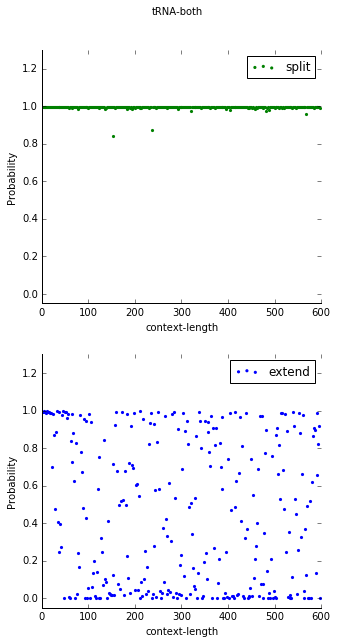

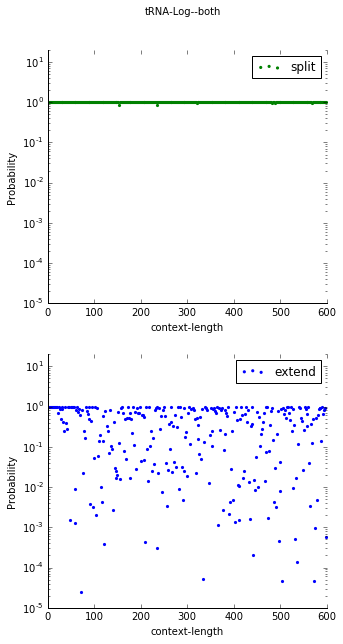

In [11]:
# df_trnaa = my_eval(trna2, context_trna2, 2, 68, 34, 2)
df_trna = my_eval(trna2, context_trna2, 3, 67, 34, 2)

print trna2
stem="CAUUGUAUUUGUAAUGCGGUG"
stem2="GCCUUUUAAAAGGC"
# df_stem = my_eval(stem, context_trna2, 3, 17, 7, 10)
# df_stemtest = my_eval(stem2, context_trna2, 3, 10, 8, 50)
# plot_scatter_df(df_stemtest, 'stem',what='both')
# plot_scatter_df(df_stem, 'stem-Log-', scale='log', what='split')
# plot_scatter_df(df_stem, 'stem',what='extend')
# plot_scatter_df(df_stem, 'stem-Log-', scale='log', what='extend')


# plot_scatter_df(df_trna_arc_b, 'tRNA arc-b')
# plot_scatter_df(df_trna_arc_b, 'tRNA arc-b Log(p(i,j))', scale='log')


plot_scatter_df(df_trna, 'tRNA',what='both')
plot_scatter_df(df_trna, 'tRNA-Log-', scale='log', what='both')

# plot_scatter_df(df_trna, 'tRNA',what='extend')
# plot_scatter_df(df_trna, 'tRNA-Log-', scale='log', what='extend')


# my_plot(trna_lengths, trna_inners, trna_outers )

[1, 3]


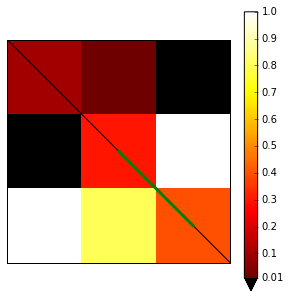

In [46]:
%matplotlib inline
mpld3.enable_notebook()

mynp = np.array([[0.1,0.01,0.001],[0.00,0.3,1.0],[1.0,0.8,.4]])
fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
# my_heatmap(mynp, fig, ax)
my_heatmap(mynp, fig, ax, inverse=False, interactive=False, gene_loc=[1,3])


72 150 100
720
[100, 172]
[100, 172]
[100, 172]
[100, 172]


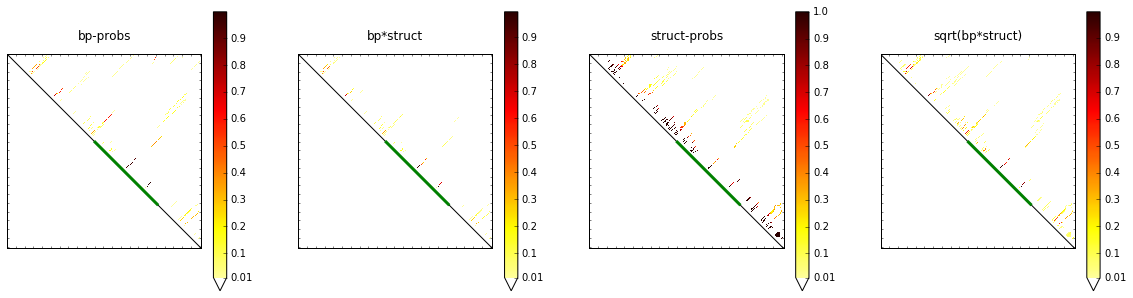

In [48]:
# RNA.get_pr(l_pos+1, r_pos+1)
context_histone_shuffled = dinuclShuffle(context_histone.upper())
context_trna2_shuffled = dinuclShuffle(context_trna2.upper())

# my_heatmaps(histone, context_histone_shuffled,context_len = 150, filename='histone-shuffled-150', 
#            what='all')
my_heatmaps(trna2, context_trna2_shuffled, insert_pos=100, context_len=150, filename='trna-shuffled-150')
# my_heatmaps(trna2, context_trna2_shuffled, context_len=0, filename='trna-shuffled-0')


In [ ]:
# tran2 >X70810.2_30807-30878
trna2="GCCUUUUUAGCUCAGUGGUAGAGCAUUGUAUUUGUAAUGCGGUGGUCGUCGGUUCGAAUCCGACAAAAGGCU"
context_trna2 = "uaugauauuuuuauaguguuuuauucauggaucaauucuauuuuuuauuagcacgugguuuuauuuuguuaaauuguaaa\
uccguauuauuuauaaauugauccuagcucaaaguucaguauuuuuaaauuuuuuuaguuuuaaauaaauauuuuguauaaaaaugugugauuauuu\
aaaagauuucuuccauuucaugacuuuuaauuuuaaaaaaaaauuucaaguauguggccauguauccguauuuggagacaagaagcaagaaaagguu\
uucuuuauaaaaaaguuuagguguuu\
uuauuuuagguaacuuuuuaagcguguuucaccggugcauucaguuuuuuuaguaaugcauaugucauugcaauuuuagcauuauguaaucuuaaa\
agcuuuugucauauuucucaacugcuaugauauauugauaggaguccuucucaauggaugcgggagaauaaauauauuguucacgguagucuaaggc\
ucauugcccccuuuuuaaagucuuagcuuucaucaugcccaggauaaaauaaucaguguugcaauaguucaaauaagcuuaauucaaaguuuauuuuagaggaucgg"
random.seed(1)
np.random.seed(10)

context_trna2_shuffled = dinuclShuffle(context_trna2.upper())
sample_trna2 = context_trna2_shuffled[0:100] + trna2 + context_trna2_shuffled[100:200]
context_trna2_shuffled = dinuclShuffle(context_trna2.upper())
sample_trna2_assymetric = context_trna2_shuffled[0:120] + trna2 + context_trna2_shuffled[120:200]

print ">sample_trna2\n", sample_trna2

In [ ]:
context_histone_shuffled = dinuclShuffle(context_histone.upper())
sample_histone = context_histone_shuffled[0:100] + histone + context_histone_shuffled[100:200]
print ">sample_histone\n", sample_histone

In [ ]:
import pickle
with open('targets-pankoff/'+ 'sample_trna_foldscore_dict' + '.pkl', 'rb') as f:
    sample_trna2_loaded_dict = pickle.load(f)

mpld3.disable_notebook()

plot_dp_ps('./targets-pankoff/cluster_10546_dp.ps')

In [ ]:
sample_np = bpp_dict_to_np_array(sample_trna2_loaded_dict, sample_trna2) 
fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
my_heatmap(sample_np, fig, ax)
fig.savefig('foldscore_sample_trna2.pdf')

In [ ]:
# plot_heat_maps(get_mfe_probs(sample_trna2), getBPPM(sample_trna2), 'sample_trna2', 'all')
plot_heat_maps(None, getBPPM(sample_trna2), 'sample_trna2_bp_probs', 'basepairs', inverse=True, interactive=True)
# plot_heat_maps(None, getBPPM(sample_trna2), 'sample_trna2_bp_probs_inverse', 'basepairs', inverse=False)
# plot_heat_maps(None, getBPPM(sample_trna2_assymetric), 'sample_trna2_bp_probs_asymmetric', 'basepairs', inverse=True)
# plot_heat_maps(None, getBPPM(sample_trna2_assymetric), 'sample_trna2_bp_probs_inverse_asymmetric', 'basepairs', inverse=False)
# plot_heat_maps(None, getBPPM(trna2), 'X70810.2_heatmap', 'basepairs', inverse=True, interactive=True)

In [ ]:
struct = ""
t = RNA.fold_compound("GCCGAAAGGC")#, struct)
print t.mfe()
t.__class__
# RNA.fold_compound.
# RNA.fold_compound.mfe(t)
# RNA.fold_compound.type()
# print t

import RNA
print RNA.__path__
structure = ""
# print RNA.pf_fold("AAGGGAAACCCAGGCGGCGC", structure)
# VRNA_VC_TYPE_SINGLE
RNA.Lfold("AAGGGAAACCCAGGCGGCGC")